<a href="https://colab.research.google.com/github/MaCuur/AI_EGs/blob/main/Procesamiento_de_datos_REALES_lluvias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Procesamiento de datos


🌧️ Código LSTM con Datos Reales (9002.csv)
Este código realiza los pasos de: 1. Carga y Reestructuración, 2. Limpieza y Escalamiento, 3. Creación de Secuencias y División, 4. Definición del Modelo (con Dropout) y 5. Entrenamiento.

1. Carga, Reestructuración y Limpieza de Datos

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- CONFIGURACIÓN DE PARÁMETROS ---
TIMESTEPS_IN = 2 #14  # Días históricos usados para predecir (Aumentamos a 14 días)
TIMESTEPS_OUT = 5  # Días a predecir simultáneamente (Día 1, 2, 3, 4, 5)
TEST_SIZE = 0.2    # 20% de los datos para la evaluación final
EPOCHS = 100       # Número de ciclos de entrenamiento
DROPOUT_RATE = 0.2 # Tasa de Dropout

# 1. Carga del Archivo CSV
try:
    # Cargar el archivo, asumiendo que la primera fila son los encabezados (Años)
    df = pd.read_csv("9002_sorted.csv")
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo '9002.csv' esté en la ubicación correcta.")
    exit()

# 2. Reestructuración a una única Serie de Tiempo Diaria
# El método .unstack() aplana el DataFrame columna por columna (Año por Año)
precipitacion_serie = df.unstack().reset_index(drop=True).rename('Precipitacion')
precipitacion_df = pd.DataFrame(precipitacion_serie)

print("--- Resumen de Datos Iniciales ---")
print(f"Total de registros cargados: {len(precipitacion_df)}")
print(f"Registros con valores NaN (faltantes): {precipitacion_df.isnull().sum().iloc[0]}")

# 3. Limpieza de Datos: Omitir los registros faltantes (NaN)
precipitacion_limpia = precipitacion_df.dropna()

# Convertir a array de NumPy
datos_limpios = precipitacion_limpia.values.astype('float32')

print(f"Total de registros limpios y usados: {len(datos_limpios)}")

# 4. Escalamiento de Datos
scaler = MinMaxScaler(feature_range=(0, 1))
datos_escalados = scaler.fit_transform(datos_limpios)

print("----------------------------------")

--- Resumen de Datos Iniciales ---
Total de registros cargados: 9882
Registros con valores NaN (faltantes): 142
Total de registros limpios y usados: 9740
----------------------------------


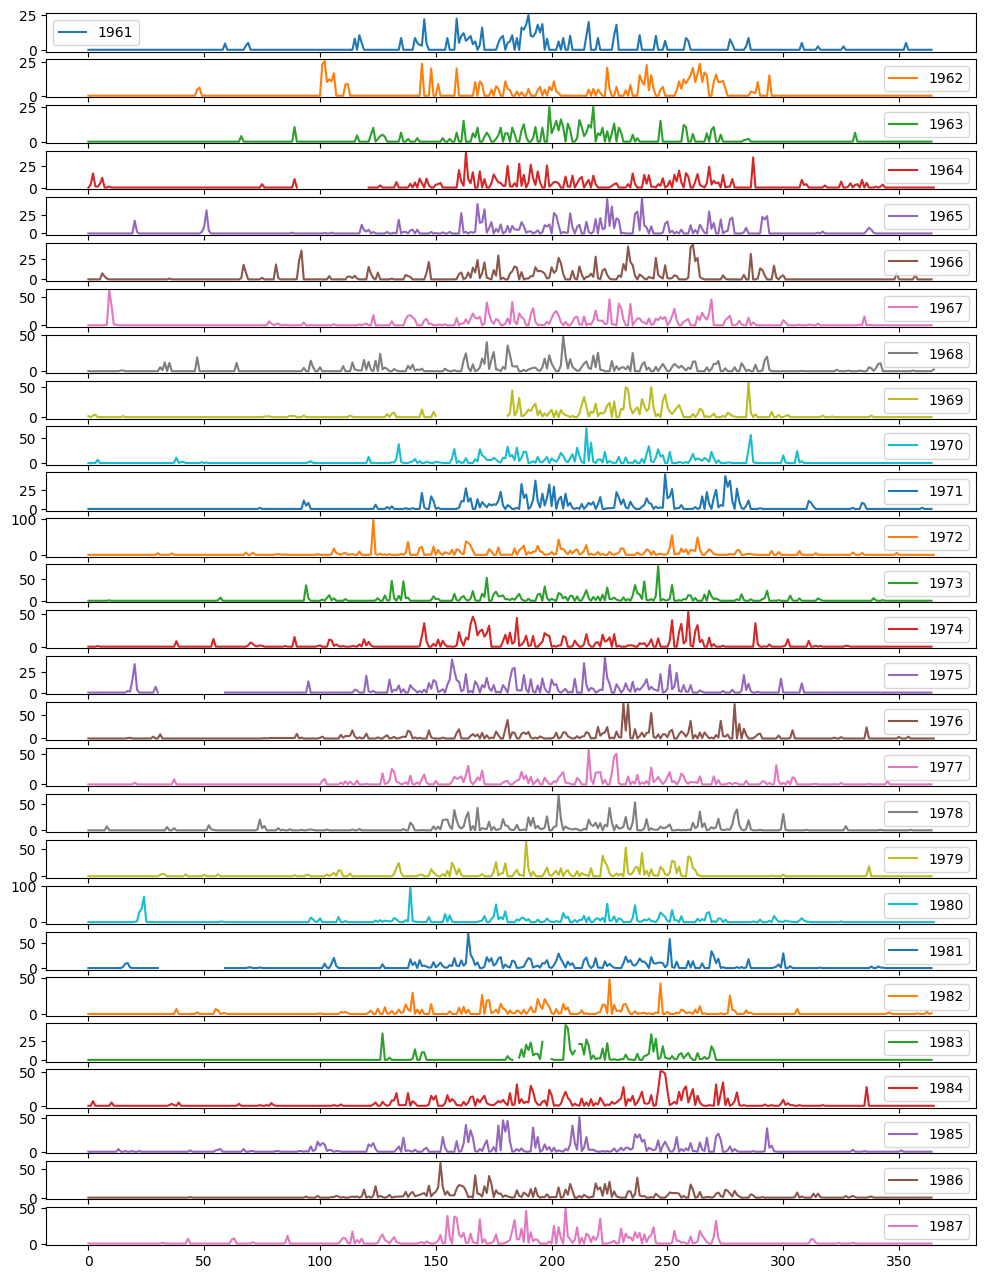

In [2]:
# Dibujemos nuestras variables
cols = df.columns

# N = 24*30*12 # Dibujar 1 año continuo
N = df.shape[0]
plots = df[cols][0:N]
plots.index = df.index[0:N]
_ = plots.plot(subplots=True, figsize=(12,16))

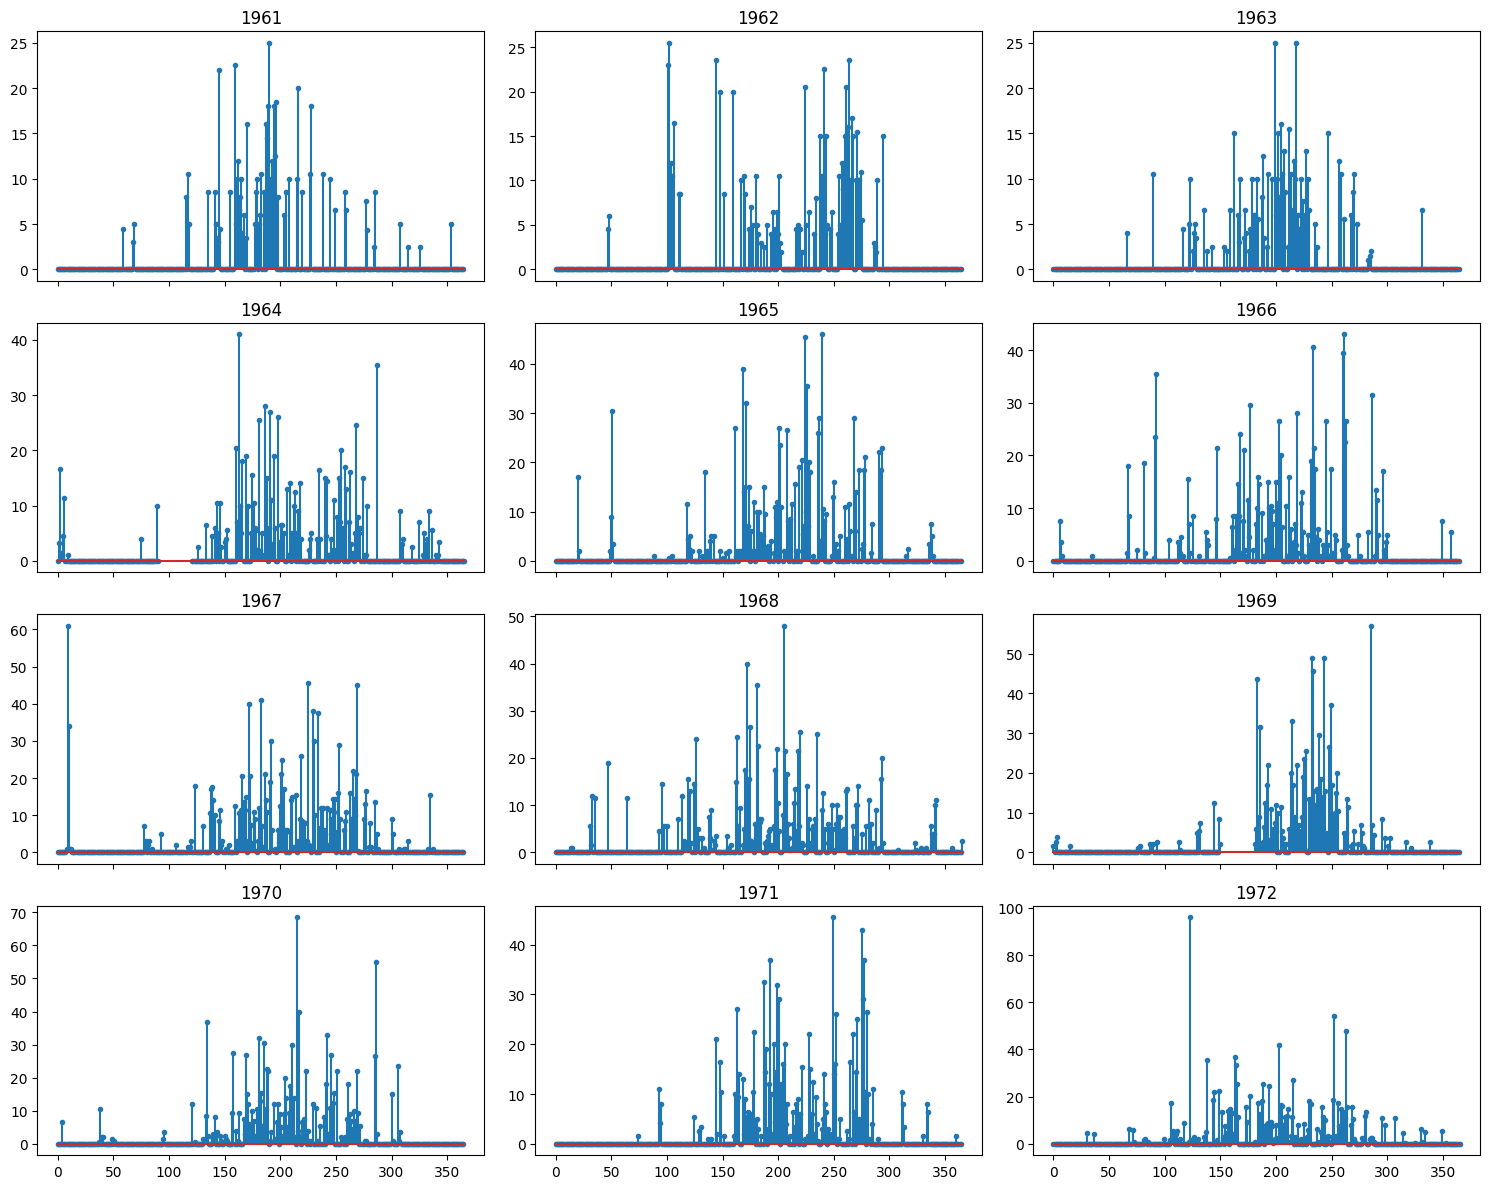

In [3]:
cols = df.columns
N = df.shape[0]
plots = df[cols].iloc[:N]

fig, axes = plt.subplots(
    nrows=4,          # ajusta según tus necesidades
    ncols=3,
    figsize=(15, 12),
    sharex=True
)

axes = axes.flatten()

for ax, col in zip(axes, cols):
    ax.stem(plots.index, plots[col],markerfmt='.',)
    ax.set_title(col)

plt.tight_layout()
plt.show()

array([[<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

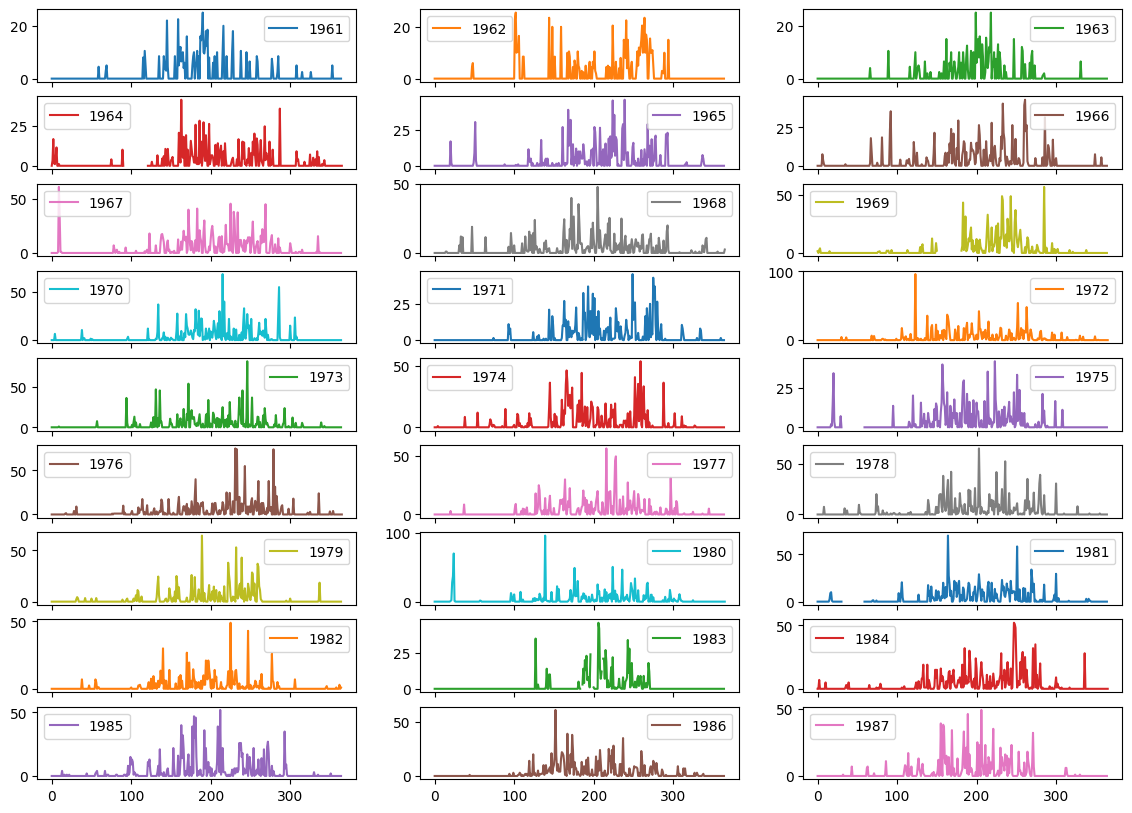

In [4]:
cols = df.columns
N = df.shape[0]
plots = df[cols].iloc[:N]

# For example, 3 columns and automatic number of rows
plots.plot(
    subplots=True,
    layout=(-1, 3),    # auto rows, 3 columns
    figsize=(14, 10),
    sharex=True
)

2. Creación de Secuencias y División de Conjuntos

In [5]:
# Función para crear las secuencias de entrada (X) y salida (y)
def crear_secuencias(datos, n_input, n_output):
    X, y = list(), list()
    for i in range(len(datos)):
        end_ix = i + n_input
        out_end_ix = end_ix + n_output

        if out_end_ix > len(datos):
            break

        seq_x = datos[i:end_ix, 0]
        seq_y = datos[end_ix:out_end_ix, 0]

        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Aplicar la función de secuencias
X, y = crear_secuencias(datos_escalados, TIMESTEPS_IN, TIMESTEPS_OUT)

# Reshape para la entrada LSTM: [muestras, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# División Temporal en Entrenamiento, Validación y Prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, shuffle=False
)
# Usar el 10% del conjunto de entrenamiento para validación
VAL_SIZE = 0.1 / (1 - TEST_SIZE) # Ajuste de tamaño
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=VAL_SIZE, shuffle=False
)

print(f"Muestras de Entrenamiento: {len(X_train)}")
print(f"Muestras de Validación: {len(X_val)}")
print(f"Muestras de Prueba: {len(X_test)}")
print("----------------------------------")

Muestras de Entrenamiento: 6813
Muestras de Validación: 974
Muestras de Prueba: 1947
----------------------------------


3. Definición, Entrenamiento y Evaluación del Modelo

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Iniciando Entrenamiento (100 Épocas) ---
Entrenamiento completado.
----------------------------------
--- Evaluación de Rendimiento (RMSE en mm) ---
**Día 1**: 6.383 mm
**Día 3**: 6.695 mm
**Día 5**: 6.714 mm


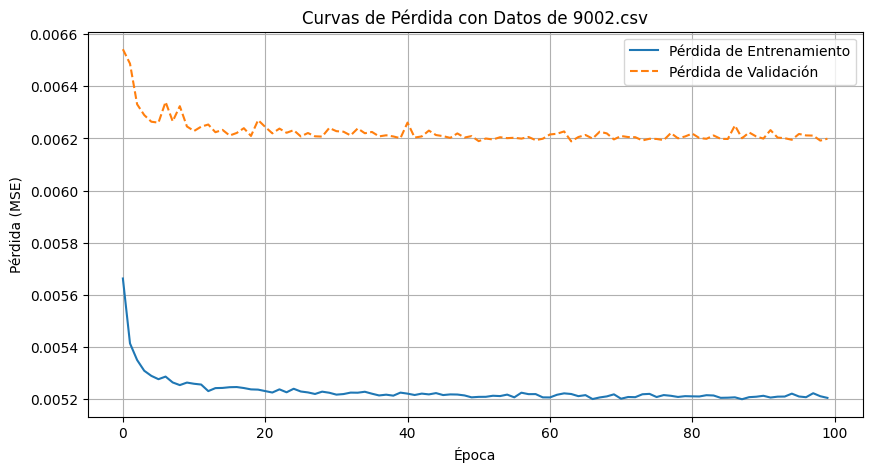


**Nota:** Para la gráfica de Predicción vs. Real, necesitaríamos más épocas y un set de datos más grande para obtener una visualización significativa.


In [6]:
from sklearn.metrics import mean_squared_error
import math

# 1. Definición del Modelo LSTM Apilado con Dropout
model = Sequential()
model.add(
    LSTM(100, activation='relu', input_shape=(TIMESTEPS_IN, 1), return_sequences=True)
)
model.add(Dropout(DROPOUT_RATE))
model.add(
    LSTM(50, activation='relu', return_sequences=False)
)
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(TIMESTEPS_OUT))
model.compile(optimizer='adam', loss='mse')


# 2. Entrenamiento del Modelo
print(f"--- Iniciando Entrenamiento ({EPOCHS} Épocas) ---")
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=0
)
print("Entrenamiento completado.")
print("----------------------------------")

# 3. Evaluación en el Conjunto de Prueba
y_pred_escalada = model.predict(X_test, verbose=0)

# 4. Invertir el escalamiento
y_test_original = scaler.inverse_transform(y_test)
y_pred_original = scaler.inverse_transform(y_pred_escalada)

# 5. Cálculo y Presentación de RMSE (para Días 1, 3 y 5)
indices = {"Día 1": 0, "Día 3": 2, "Día 5": 4}

print("--- Evaluación de Rendimiento (RMSE en mm) ---")
for horizonte, idx in indices.items():
    # Calcular RMSE
    rmse = math.sqrt(mean_squared_error(y_test_original[:, idx], y_pred_original[:, idx]))
    print(f"**{horizonte}**: {rmse:.3f} mm")

# 6. Gráfica de Pérdida (para diagnóstico de Overfitting)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación', linestyle='--')
plt.title('Curvas de Pérdida con Datos de 9002.csv')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()


print("\n**Nota:** Para la gráfica de Predicción vs. Real, necesitaríamos más épocas y un set de datos más grande para obtener una visualización significativa.")

Este código utiliza tu archivo CSV real para predecir la precipitación acumulada diaria en los horizontes de 1, 3 y 5 días.El siguiente paso lógico, después de revisar el RMSE y la curva de pérdida, es aplicar la mejor técnica de mejora de rendimiento que discutimos (por ejemplo, Early Stopping, el uso de datos multivariados o el ajuste de $T_{in}$).

🛑 Implementación de Parada Temprana (Early Stopping)
El siguiente código retoma el paso de entrenamiento del ejemplo anterior e introduce el callback EarlyStopping.

1. Definición del Callback
Definimos los parámetros clave:

monitor='val_loss': La métrica que queremos monitorear (la pérdida en el conjunto de validación).

patience=15: El número de épocas que el modelo esperará sin que haya una mejora en val_loss antes de detenerse.

restore_best_weights=True: Vuelve a cargar los pesos del modelo que logró el mejor rendimiento en la pérdida de validación.

2. Código Actualizado para el Entrenamiento
Continuamos desde donde se generaron los conjuntos de datos (X_train, y_train, X_val, y_val).

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Iniciando Entrenamiento (Máx 200 Épocas con Early Stopping) ---
La paciencia (patience) es de 15 épocas sin mejora en val_loss.
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 17.
Entrenamiento completado y detenido en la época: 32
----------------------------------


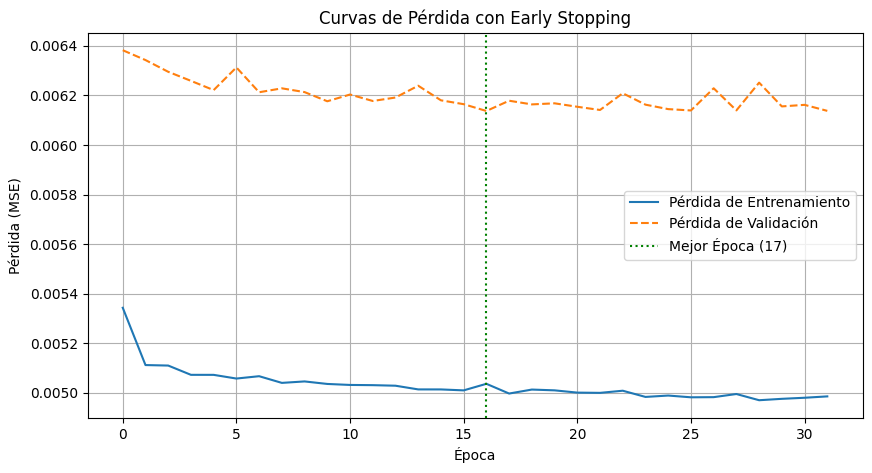

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import math
import matplotlib.pyplot as plt

# --- CONFIGURACIÓN DE PARÁMETROS ---
TIMESTEPS_IN = 14
TIMESTEPS_OUT = 5
TEST_SIZE = 0.2
EPOCHS = 200      # Aumentamos las épocas máximas, ya que Early Stopping nos detendrá
DROPOUT_RATE = 0.2
PATIENCE = 15     # Parámetro de Early Stopping

# --- RE-DEFINICIÓN DE VARIABLES DE DATOS PARA ASEGURAR EL CONTEXTO ---
# 1. Carga del Archivo CSV (repetido para asegurar disponibilidad)
try:
    df = pd.read_csv("9002_sorted.csv")
except FileNotFoundError:
    print("Error: Asegúrate de que el archivo '9002.csv' esté en la ubicación correcta.")
    exit()

# 2. Reestructuración a una única Serie de Tiempo Diaria
precipitacion_serie = df.unstack().reset_index(drop=True).rename('Precipitacion')
precipitacion_df = pd.DataFrame(precipitacion_serie)

# 3. Limpieza de Datos: Omitir los registros faltantes (NaN)
precipitacion_limpia = precipitacion_df.dropna()
datos_limpios = precipitacion_limpia.values.astype('float32')

# 4. Escalamiento de Datos
scaler = MinMaxScaler(feature_range=(0, 1))
datos_escalados = scaler.fit_transform(datos_limpios)

# Función para crear las secuencias de entrada (X) y salida (y) (repetido)
def crear_secuencias(datos, n_input, n_output):
    X_seq, y_seq = list(), list()
    for i in range(len(datos)):
        end_ix = i + n_input
        out_end_ix = end_ix + n_output

        if out_end_ix > len(datos):
            break

        seq_x = datos[i:end_ix, 0]
        seq_y = datos[end_ix:out_end_ix, 0]

        X_seq.append(seq_x)
        y_seq.append(seq_y)
    return np.array(X_seq), np.array(y_seq)

# Aplicar la función de secuencias
X, y = crear_secuencias(datos_escalados, TIMESTEPS_IN, TIMESTEPS_OUT)

# Reshape para la entrada LSTM: [muestras, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# División Temporal en Entrenamiento, Validación y Prueba
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, shuffle=False
)
VAL_SIZE = 0.1 / (1 - TEST_SIZE) # Ajuste de tamaño
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=VAL_SIZE, shuffle=False
)
# --- FIN DE RE-DEFINICIÓN DE VARIABLES DE DATOS ---

# 1. Definición del Modelo (Mismo modelo LSTM Apilado con Dropout)
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(TIMESTEPS_IN, 1), return_sequences=True))
model.add(Dropout(DROPOUT_RATE))
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(TIMESTEPS_OUT))
model.compile(optimizer='adam', loss='mse')

# ----------------------------------------------------
# 2. Implementación de Parada Temprana (Early Stopping)
# ----------------------------------------------------
early_stopping = EarlyStopping(
    monitor='val_loss',         # Métrica a monitorear
    patience=PATIENCE,          # Número de épocas sin mejora antes de parar
    restore_best_weights=True,  # Cargar los mejores pesos encontrados
    verbose=1                   # Muestra un mensaje cuando se detiene
)

# 3. Entrenamiento del Modelo con el Callback
print(f"--- Iniciando Entrenamiento (Máx {EPOCHS} Épocas con Early Stopping) ---")
print(f"La paciencia (patience) es de {PATIENCE} épocas sin mejora en val_loss.")

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping], # AÑADIMOS EL CALLBACK AQUÍ
    verbose=0
)

# El entrenamiento se detendrá automáticamente cuando se cumpla la condición de Early Stopping.
final_epoch = len(history.history['loss'])
print(f"Entrenamiento completado y detenido en la época: {final_epoch}")
print("----------------------------------")

# 4. Gráfica de Pérdida
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación', linestyle='--')

# Calcular la mejor época para la línea vertical
best_epoch_idx = np.argmin(history.history['val_loss'])
plt.axvline(x=best_epoch_idx, color='green', linestyle=':', label=f'Mejor Época ({best_epoch_idx + 1})')

plt.title('Curvas de Pérdida con Early Stopping')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.legend()
plt.grid(True)
plt.show()


# 5. Evaluación Final (Opcional, pero esencial para el rendimiento)
# (Aquí iría el código de predicción e inversión de escalamiento para calcular el RMSE en X_test)


Al utilizar EarlyStopping, el modelo se detendrá tan pronto como el rendimiento en el conjunto de validación ya no mejore significativamente. Esto no solo previene el sobreajuste, sino que también garantiza que tu modelo final utiliza los pesos que mejor generalizan.

5. Evaluación Final (Predicción e Inversión de Escalamiento)
Este bloque de código debe ejecutarse después de que el modelo haya sido entrenado y detenido por el Early Stopping.

In [8]:
# --- Asumiendo que el modelo (model) ha sido entrenado y las variables de prueba
# (X_test, y_test) y el escalador (scaler) están disponibles ---

# 1. Predicción sobre el conjunto de prueba (Test Set)
print("--- Iniciando Evaluación Final sobre X_test ---")
y_pred_escalada = model.predict(X_test, verbose=0)

# 2. Invertir el escalamiento para las predicciones y los valores reales de prueba
# Esto devuelve los datos a la escala original (mm de precipitación)
try:
    y_test_original = scaler.inverse_transform(y_test)
    y_pred_original = scaler.inverse_transform(y_pred_escalada)
except AttributeError:
    # Esto puede ocurrir si el scaler no fue ajustado correctamente en los pasos previos
    print("\nError: El objeto 'scaler' no está disponible o no fue ajustado (fit) correctamente.")
    print("Asegúrate de ejecutar las secciones 1 y 2 completas para cargar y escalar los datos.")
    exit()

# 3. Cálculo y Presentación de RMSE (para Días 1, 3 y 5)
indices = {
    "Día 1": 0,  # Índice 0 de la salida de 5 días
    "Día 3": 2,  # Índice 2 de la salida de 5 días
    "Día 5": 4   # Índice 4 de la salida de 5 días
}

print("\n--- Resultados de Rendimiento (RMSE en mm) ---")

for horizonte, idx in indices.items():
    # Extraer los datos para el horizonte específico
    y_test_horizonte = y_test_original[:, idx]
    y_pred_horizonte = y_pred_original[:, idx]

    # Calcular RMSE (Raíz del Error Cuadrático Medio)
    mse = mean_squared_error(y_test_horizonte, y_pred_horizonte)
    rmse = math.sqrt(mse)

    print(f"**{horizonte}** a futuro:")
    print(f"  RMSE: {rmse:.3f} mm")

print("\n**Interpretación:** El RMSE indica el error promedio del pronóstico en la unidad original (mm).")

--- Iniciando Evaluación Final sobre X_test ---

--- Resultados de Rendimiento (RMSE en mm) ---
**Día 1** a futuro:
  RMSE: 6.367 mm
**Día 3** a futuro:
  RMSE: 6.543 mm
**Día 5** a futuro:
  RMSE: 6.594 mm

**Interpretación:** El RMSE indica el error promedio del pronóstico en la unidad original (mm).


Este código completa la evaluación, dándote la métrica de rendimiento más importante para tu proyecto.

Para continuar mejorando el modelo, el siguiente paso sería visualizar la predicción final (similar al paso anterior, pero ahora con los pesos optimizados por Early Stopping) para ver cómo se comporta el modelo en los datos de prueba no vistos.

Una vez que hemos obtenido los valores finales de RMSE, la visualización de la curva de predicción es el paso final para entender la calidad del pronóstico de tu modelo sobre los datos que nunca ha visto.

Generaremos la gráfica para el Día 3 a futuro (el horizonte intermedio), ya que tienes las variables y_test_original y y_pred_original de la sección anterior.

📊 Visualización de Predicciones (Día 3 a Futuro)
Este código utiliza la librería matplotlib para comparar la precipitación real (y_test_original) con la predicción del modelo (y_pred_original) para el horizonte de interés:

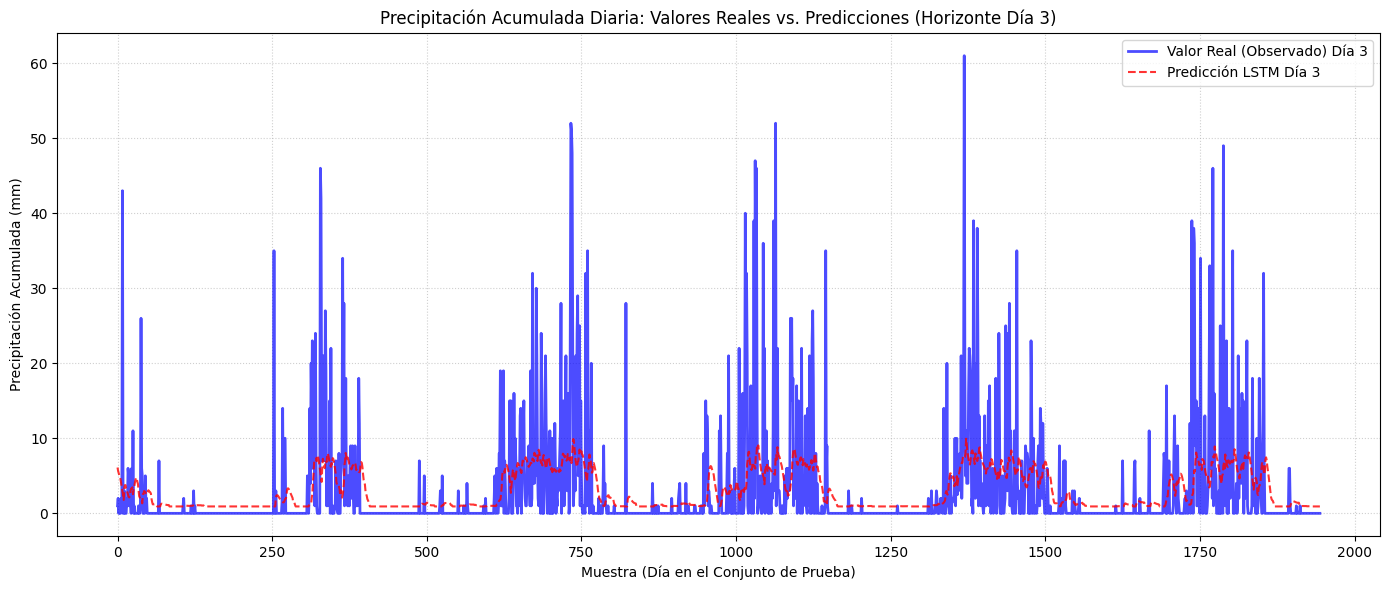

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# --- Asumiendo que las variables y_test_original y y_pred_original ya fueron calculadas ---
# y_test_original.shape = (muestras_test, 5)
# y_pred_original.shape = (muestras_test, 5)

# 1. Seleccionar el horizonte de interés (Día 3)
HORIZONTE_INDEX = 2  # Índice 2 corresponde al Día 3 a futuro

y_test_dia3 = y_test_original[:, HORIZONTE_INDEX]
y_pred_dia3 = y_pred_original[:, HORIZONTE_INDEX]

# 2. Crear un rango de índices para el eje X (las muestras del conjunto de prueba)
muestras_test = np.arange(len(y_test_dia3))

# 3. Generar la gráfica
plt.figure(figsize=(14, 6))

# Valores Reales
plt.plot(muestras_test, y_test_dia3,
         label='Valor Real (Observado) Día 3',
         color='blue',
         alpha=0.7,
         linewidth=2)

# Predicciones del Modelo
plt.plot(muestras_test, y_pred_dia3,
         label='Predicción LSTM Día 3',
         color='red',
         alpha=0.8,
         linestyle='--')

plt.title('Precipitación Acumulada Diaria: Valores Reales vs. Predicciones (Horizonte Día 3)')
plt.xlabel('Muestra (Día en el Conjunto de Prueba)')
plt.ylabel('Precipitación Acumulada (mm)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

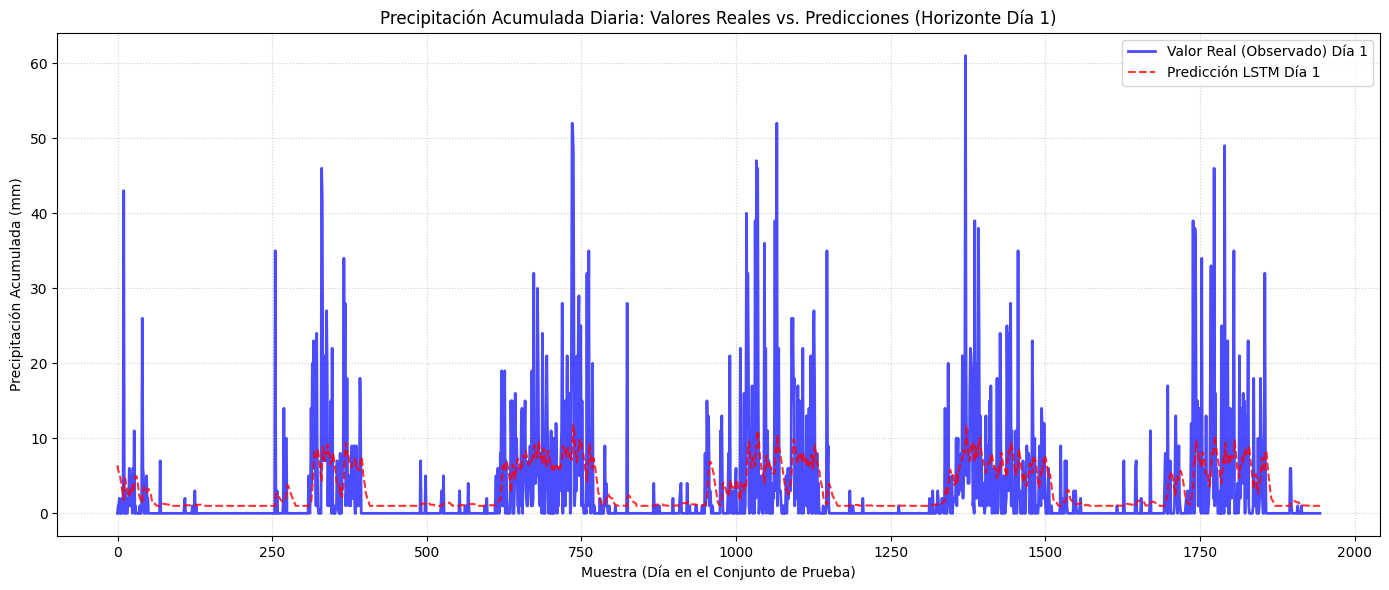

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# --- Asumiendo que las variables y_test_original y y_pred_original ya fueron calculadas ---
# y_test_original.shape = (muestras_test, 5)
# y_pred_original.shape = (muestras_test, 5)

# 1. Seleccionar el horizonte de interés (Día 3)
HORIZONTE_INDEX = 0  # Índice 2 corresponde al Día 3 a futuro

y_test_dia0 = y_test_original[:, HORIZONTE_INDEX]
y_pred_dia0 = y_pred_original[:, HORIZONTE_INDEX]

# 2. Crear un rango de índices para el eje X (las muestras del conjunto de prueba)
muestras_test = np.arange(len(y_test_dia0))

# 3. Generar la gráfica
plt.figure(figsize=(14, 6))

# Valores Reales
plt.plot(muestras_test, y_test_dia0,
         label='Valor Real (Observado) Día 1',
         color='blue',
         alpha=0.7,
         linewidth=2)

# Predicciones del Modelo
plt.plot(muestras_test, y_pred_dia0,
         label='Predicción LSTM Día 1',
         color='red',
         alpha=0.8,
         linestyle='--')

plt.title('Precipitación Acumulada Diaria: Valores Reales vs. Predicciones (Horizonte Día 1)')
plt.xlabel('Muestra (Día en el Conjunto de Prueba)')
plt.ylabel('Precipitación Acumulada (mm)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

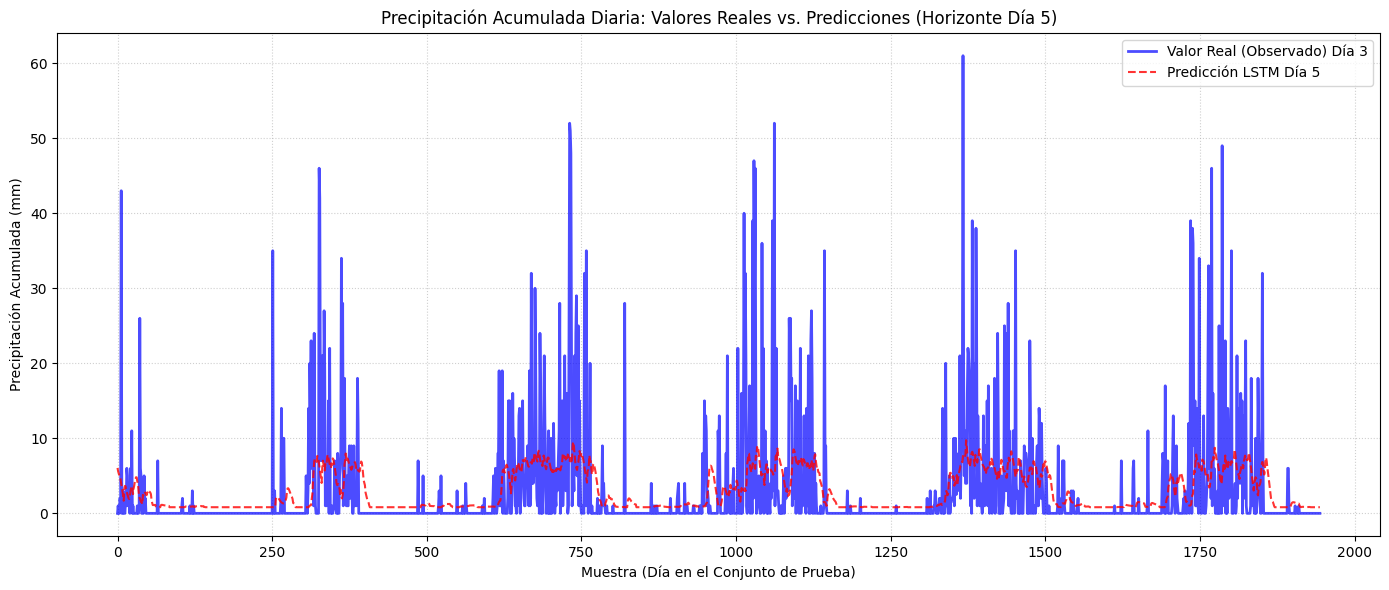

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# --- Asumiendo que las variables y_test_original y y_pred_original ya fueron calculadas ---
# y_test_original.shape = (muestras_test, 5)
# y_pred_original.shape = (muestras_test, 5)

# 1. Seleccionar el horizonte de interés (Día 3)
HORIZONTE_INDEX = 4  # Índice 2 corresponde al Día 3 a futuro

y_test_dia4 = y_test_original[:, HORIZONTE_INDEX]
y_pred_dia4 = y_pred_original[:, HORIZONTE_INDEX]

# 2. Crear un rango de índices para el eje X (las muestras del conjunto de prueba)
muestras_test = np.arange(len(y_test_dia4))

# 3. Generar la gráfica
plt.figure(figsize=(14, 6))

# Valores Reales
plt.plot(muestras_test, y_test_dia4,
         label='Valor Real (Observado) Día 3',
         color='blue',
         alpha=0.7,
         linewidth=2)

# Predicciones del Modelo
plt.plot(muestras_test, y_pred_dia4,
         label='Predicción LSTM Día 5',
         color='red',
         alpha=0.8,
         linestyle='--')

plt.title('Precipitación Acumulada Diaria: Valores Reales vs. Predicciones (Horizonte Día 5)')
plt.xlabel('Muestra (Día en el Conjunto de Prueba)')
plt.ylabel('Precipitación Acumulada (mm)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

Análisis de la Gráfica
Si el modelo es bueno: La línea roja (Predicción) debería seguir la forma general de la línea azul (Real), especialmente en los patrones base (días secos).

Dificultad con Picos: Es común que, en la predicción de precipitación, el modelo tienda a suavizar los picos de lluvia extrema. Puede predecir que habrá lluvia, pero subestimar la magnitud.

Este flujo de trabajo —desde la carga del CSV hasta la visualización de la predicción final con Early Stopping— constituye un modelo LSTM robusto y bien evaluado para tu proyecto.

1. Guardar y Recargar el Modelo Entrenado
El modelo que acabas de entrenar con Early Stopping (model) contiene los pesos óptimos. Usaremos el formato nativo de Keras (.keras) para guardar tanto la arquitectura como los pesos del modelo.

A. Guardar el Modelo y el Escalador
Es crucial guardar el escalador (scaler) junto con el modelo, ya que necesitarás usar exactamente el mismo escalador para normalizar los nuevos datos de entrada antes de hacer una predicción.

In [12]:
import joblib
from tensorflow.keras.models import load_model

# --- Asumiendo que 'model' y 'scaler' están disponibles del proceso anterior ---

# 1. Definir los nombres de los archivos
MODELO_PATH = 'lstm_precipitacion.keras'
SCALER_PATH = 'scaler_precipitacion.pkl'

# 2. Guardar el Modelo (arquitectura + pesos)
model.save(MODELO_PATH)
print(f"✅ Modelo guardado exitosamente en: {MODELO_PATH}")

# 3. Guardar el Escalador (para poder desescalar futuras predicciones)
joblib.dump(scaler, SCALER_PATH)
print(f"✅ Escalador guardado exitosamente en: {SCALER_PATH}")

✅ Modelo guardado exitosamente en: lstm_precipitacion.keras
✅ Escalador guardado exitosamente en: scaler_precipitacion.pkl


B. Recargar y Usar el Modelo para Predicción
Para usar el modelo en el futuro (por ejemplo, en un script de producción), simplemente lo recargas:

In [13]:
# --- Función de ejemplo para recargar y hacer una predicción ---

def predecir_precipitacion_futura(datos_nuevos_historicos):
    # 1. Recargar el modelo y el escalador
    cargado_model = load_model(MODELO_PATH)
    cargado_scaler = joblib.load(SCALER_PATH)

    # 2. Preparar los datos de entrada (deben ser los 14 días históricos)
    datos_entrada = datos_nuevos_historicos.reshape(-1, 1).astype('float32') # Asegurar la forma

    # 3. Escalar los datos de entrada (USANDO SOLO EL MÉTODO 'TRANSFORM')
    datos_escalados_input = cargado_scaler.transform(datos_entrada)

    # 4. Reshape para LSTM: [1, TIMESTEPS_IN, 1]
    X_input = datos_escalados_input.reshape(1, TIMESTEPS_IN, 1)

    # 5. Hacer la predicción
    y_pred_escalada = cargado_model.predict(X_input, verbose=0)

    # 6. Invertir el escalamiento de la predicción
    y_pred_original = cargado_scaler.inverse_transform(y_pred_escalada)

    return y_pred_original.flatten()

# Ejemplo: Simular los últimos 14 días de datos de precipitación
# (¡En la vida real, usarías los últimos 14 días reales de tu estación!)
datos_ejemplo = np.array([0.0, 1.2, 0.5, 0.0, 3.5, 0.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 0.0, 4.1])
if len(datos_ejemplo) == TIMESTEPS_IN:
    pronostico = predecir_precipitacion_futura(datos_ejemplo)

    print("\n--- Predicción Usando Modelo Guardado ---")
    print(f"Pronóstico (Día 1, 2, 3, 4, 5): {pronostico}")
    print(f"Precipitación Día 3 a futuro: {pronostico[2]:.2f} mm")


--- Predicción Usando Modelo Guardado ---
Pronóstico (Día 1, 2, 3, 4, 5): [1.4469367 1.2719082 1.4086729 1.3222353 1.2797432]
Precipitación Día 3 a futuro: 1.41 mm


2. Explorar la Integración Multivariada
Para mejorar la precisión, debes alimentar a tu red LSTM no solo con la precipitación histórica, sino también con otras variables meteorológicas clave (conocidas como features o características).

A. Preprocesamiento Multivariado
El principal cambio es que ahora tu entrada X tendrá más de una característica.

Asunción: Necesitas un nuevo archivo CSV (datos_multivariados.csv) con columnas como: Precipitacion, Temperatura, Humedad, etc., todas alineadas por fecha.

In [14]:
# --- Ejemplo conceptual de cómo cambiaría tu entrada ---
# Asumimos que tienes N_FEATURES = 3 (Precipitación, Temp, Humedad)

N_FEATURES = 3 # Por ejemplo, [Precipitación, Temperatura, Humedad]

# 1. Cargar y Limpiar Datos Multivariados
# df_multi = pd.read_csv('datos_multivariados.csv').dropna().values.astype('float32')

# 2. Escalar los datos (debes escalar CADA columna)
# scaler_multi = MinMaxScaler(feature_range=(0, 1))
# datos_escalados_multi = scaler_multi.fit_transform(df_multi)

# 3. Adaptar la Función de Secuencias: Y (salida) sigue siendo solo Precipitación
# Se necesitaría adaptar la función 'crear_secuencias' para manejar X con múltiples columnas
# pero y (salida) con una sola.
# X_multi, y_uni = crear_secuencias_multi(datos_escalados_multi, TIMESTEPS_IN, TIMESTEPS_OUT, target_col=0) # Asumiendo Precipitación en col 0

# 4. Reshape para LSTM: [muestras, timesteps, N_FEATURES]
# X_multi.shape ahora sería: (muestras, 14, 3)
# y_uni.shape seguiría siendo: (muestras, 5)

B. Arquitectura Multivariada
Solo necesitas cambiar la forma de la entrada en la primera capa LSTM:

In [15]:
# --- Definición del Modelo Multivariado ---

model_multi = Sequential()
model_multi.add(
    LSTM(100,
         activation='relu',
         # CAMBIO CLAVE: input_shape debe ser (TIMESTEPS_IN, N_FEATURES)
         input_shape=(TIMESTEPS_IN, N_FEATURES),
         return_sequences=True)
)
model_multi.add(Dropout(0.2))
model_multi.add(
    LSTM(50, activation='relu', return_sequences=False)
)
model_multi.add(Dropout(0.2))
model_multi.add(Dense(TIMESTEPS_OUT)) # La salida sigue siendo 5 valores de Precipitación
model_multi.compile(optimizer='adam', loss='mse')

print("\n--- Arquitectura Multivariada ---")
model_multi.summary()


--- Arquitectura Multivariada ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 14, 100)        │        41,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 14, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 72,055 (281.46 KB)

 Trainable params: 72,055 (281.46 KB)

 Non-trainable params: 0 (0.00 B)

Al incluir variables como la temperatura y la humedad, la capa LSTM tendrá mucha más información para aprender la dinámica del clima, lo que debería resultar en un RMSE más bajo que tu modelo univariado actual.

Resumen de la tarea pendiente: El siguiente paso es conseguir o crear un archivo de datos multivariados y adaptar la función crear_secuencias para que maneje un X de múltiples características.